### Functions and script to interface with recorded Harp Binaries

**Inputs:**
- Binary files in session folder saved in 'Behavior.harp', and 'SoundCard.harp' subdirectories.<br>
- Experimental data .csv file in 'Experimental-data' subdirectory containing trial-level behavioural data output directory from Bonsai workflow.

**Key outputs**
- trials_df data frame containing a summary of behavioural events in each trial including harp timestamps for dot onset and offset, nose pokes, and audio onset and offset times within each trial. Note that this data set contains redundancy to double check consistency of trial information between this script and the Bonsai output. 

**Overview** 
1. Create a general reader for the harp behavior board binaries and another specifically for register 32 of the sound card.
2. Align key behavioural events to trials in a pandas data frame in which each row represents one trial. 
3. Append harp data frame to behavioural summary data frame containing trial-level information.


In [1]:
# Import main libraries and define data folder
import harp
import pandas as pd
import os
import matplotlib.pyplot as plt

import utils.harp_utils as hu
import utils.plot_utils as pu

#==============================================================================
animal_ID = 'FNT099'
session_ID = '2024-05-13T11-03-59'

# animal_ID = 'FNT107'
# session_ID = '2024-08-11T14-01-24'

# path behavioural data on ceph repo
input_dir = r"W:\projects\FlexiVexi\raw_data" 
output_dir = (r"C:\Users\megan\Documents\sjlab\flexible-navigation-task" +
              r"\data_analysis\intermediate_variables")

#==============================================================================

# Create reader for behavior.
bin_b_path = os.path.join(input_dir, animal_ID, session_ID, "Behavior.harp")
behavior_reader = harp.create_reader(bin_b_path)

# Specify mapping from sound index to reward port
soundIdx0 = 14
soundIdx1 = 10
soundOffIdx = 18

**Get harp TTL data frame**

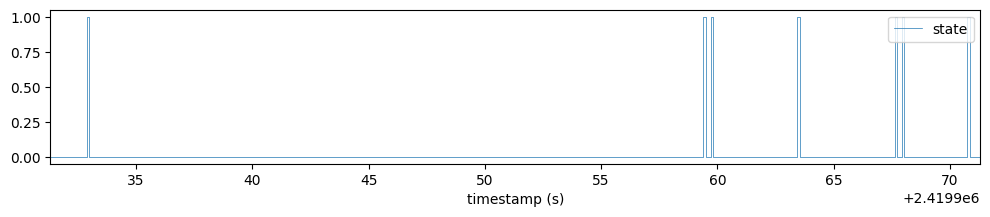

Text(0.5, 1.0, 'Plot TTL pulses, 2024-05-13T11-03-59')

In [2]:
#%matplotlib inline
def plot_ttl_trace(ttl_state_df, *, t_start, t_end):

    fig, ax = plt.subplots(figsize=(12, 2))  # Set the figure size (width, height) in inches
    ttl_pulse = hu.get_square_wave(ttl_state_df)
    ttl_pulse.plot(x='timestamp', y='state', linewidth=0.5, ax=ax)
    ax.set_xlabel('timestamp (s)')
    ax.legend(loc='upper right')
    ax.set_xlim(t_start, t_end)

    plt.show()

    return fig, ax

# Get data frame with state of TTL pulse
ttl_state_df = hu.get_ttl_state_df(behavior_reader)

# Plot ttl trace
t0 = ttl_state_df['timestamp'].iloc[0]

fig, ax = plot_ttl_trace(ttl_state_df, t_start=t0, t_end=t0 + 40)
ax.set_title("Plot TTL pulses, " + session_ID)

**Align dot times with experimental-data-csv**
 
 --> Need to phase out of using this!!

In [3]:
# Import behavioral data as data frame
session_path = os.path.join(input_dir, animal_ID, session_ID)
filepath = os.path.join(session_path, 'Experimental-data', session_ID + '_experimental-data.csv')
trials_df = pd.read_csv(filepath)

# Get dot onset and offset times given by TTL pulses

## First dot onset time from software clock (used as a common sense check for inconsistencies with number of TTL pulses on start up)
t0 = trials_df['DotOnsetTime'].iloc[0]

## Get dot times from TTL pulses
[dot_times_ttl, ttl_state_0] = hu.get_dot_times_from_ttl(behavior_reader, t0, return_TTL_state_at_startup=True)
print('TTL state upon start-up: ', ttl_state_0)

# Append dot onset and offset times given by TTL pulses to trials_df
trials_df = pd.concat([trials_df, dot_times_ttl],axis=1)

# Common sense check that the logic of aligning the TTL pulses is working as expected.
# Check dot onset and times from software clock TTL pulses are consistent, given by:
# - DotOnsetTime = dot onset time from software clock
# - DotOnsetTime_ttl = dot onset time from TTL pulses
# - DotOffsetTime = dot offset time from software clock
# - DotOffsetTime_ttl = dot offset time from TTL pulses

trials_df[['TrialStart', 'DotOnsetTime', 'DotOffsetTime', 'DotOnsetTime_harp_ttl', 'DotOffsetTime_harp_ttl']]

TTL state upon start-up:  0


,TrialStart,DotOnsetTime,DotOffsetTime,DotOnsetTime_harp_ttl,DotOffsetTime_harp_ttl
0,2.419933e+06,2.419933e+06,2.419959e+06,2.419933e+06,2.419959e+06
1,2.419963e+06,2.419963e+06,2.419968e+06,2.419963e+06,2.419968e+06
2,2.419971e+06,2.419971e+06,2.420007e+06,2.419971e+06,2.420007e+06
3,2.420013e+06,2.420013e+06,2.420024e+06,2.420013e+06,2.420024e+06
4,2.420029e+06,2.420029e+06,2.420036e+06,2.420029e+06,2.420036e+06
...,...,...,...,...,...
263,2.423114e+06,2.423114e+06,2.423117e+06,2.423114e+06,2.423117e+06
264,2.423121e+06,2.423121e+06,2.423123e+06,2.423121e+06,2.423123e+06
265,2.423125e+06,2.423125e+06,2.423130e+06,2.423125e+06,2.423130e+06
266,2.423132e+06,2.423132e+06,2.423138e+06,2.423132e+06,2.423138e+06


**Get all poke events**

In [4]:
# Read the behavior harp stream, Digital Input states for the nosepoke timestamps and IDs. Drop DI3 <-- What's DI3??
all_pokes = behavior_reader.DigitalInputState.read()

all_pokes.drop(columns=['DI3','DIPort2'],inplace = True) # remove all nose pokes to dummy port
#all_pokes.reset_index(inplace=True)

# Show resulting data frame
all_pokes.head()

,DIPort0,DIPort1
Time,,
2.419931e+06,False,False
2.419953e+06,True,False
2.419954e+06,False,False
2.419954e+06,True,False
2.419954e+06,False,False


**Get all audio events**

In [5]:
# Load the sound card binary data (register 32) and show resulting dataframe
bin_sound_path = os.path.join(input_dir, animal_ID, session_ID, "SoundCard.harp","SoundCard_32.bin")

# Read the harp sound card stream, for the timestamps and audio ID
all_sounds = hu.get_all_sounds(bin_sound_path)

# Show dataframe
all_sounds

,Time,PlaySoundOrFrequency
0,2.419953e+06,14
1,2.419961e+06,18
2,2.419963e+06,10
3,2.419969e+06,18
4,2.419983e+06,14
...,...,...
1073,2.423130e+06,18
1074,2.423136e+06,10
1075,2.423138e+06,18
1076,2.423143e+06,10


**Get trial start times in harp clock**
This will be redundant in our final version of the code! We don't want to define trail start in stage 4 by TTL data or photodiode data since both are too error prone. Instead, move to TrailStart from Bonsai output (currently 'experimental-data.csv').

In [6]:
# check training stage specified in 'trials_df'
stage = trials_df['TrainingStage'].iloc[0]

# get trial start times for the specified stage
if stage == 4:
    dot_onset_times = trials_df['DotOnsetTime_harp_ttl']
    trial_start_times = hu.get_trial_start_times(4, dot_onset_times=dot_onset_times)
elif stage == 5:
    trial_start_times = hu.get_trial_start_times(5, bin_sound_path=bin_sound_path, sound_reader=sound_reader)

# Append trial start times to trials_df
trials_df = pd.concat([trials_df, trial_start_times.rename('TrialStart_harp')],axis=1)

trials_df[['TrialStart', 'TrialStart_harp', 'DotOnsetTime', 'DotOffsetTime', 'DotOnsetTime_harp_ttl', 'DotOffsetTime_harp_ttl']]

,TrialStart,TrialStart_harp,DotOnsetTime,DotOffsetTime,DotOnsetTime_harp_ttl,DotOffsetTime_harp_ttl
0,2.419933e+06,2.419933e+06,2.419933e+06,2.419959e+06,2.419933e+06,2.419959e+06
1,2.419963e+06,2.419963e+06,2.419963e+06,2.419968e+06,2.419963e+06,2.419968e+06
2,2.419971e+06,2.419971e+06,2.419971e+06,2.420007e+06,2.419971e+06,2.420007e+06
3,2.420013e+06,2.420013e+06,2.420013e+06,2.420024e+06,2.420013e+06,2.420024e+06
4,2.420029e+06,2.420029e+06,2.420029e+06,2.420036e+06,2.420029e+06,2.420036e+06
...,...,...,...,...,...,...
263,2.423114e+06,2.423114e+06,2.423114e+06,2.423117e+06,2.423114e+06,2.423117e+06
264,2.423121e+06,2.423121e+06,2.423121e+06,2.423123e+06,2.423121e+06,2.423123e+06
265,2.423125e+06,2.423125e+06,2.423125e+06,2.423130e+06,2.423125e+06,2.423130e+06
266,2.423132e+06,2.423132e+06,2.423132e+06,2.423138e+06,2.423132e+06,2.423138e+06


**Align poke events with trials**

Get data frame with port choice ID and timestamp for each trial, where the port choice is taken as the first nose poke within the response window (between dot offset and trial end). If the trial is aborted, the port ID and timestamp are both taken as NaN.

In [7]:
# Get data frame with port choice ID and timestamp for each trial
port_choice_df = hu.get_port_choice(trials_df, behavior_reader)

# Append port choice to trials_df
trials_df = pd.concat([trials_df, port_choice_df],axis=1)

# Show port choice data frame
port_choice_df.head()

,ChoicePort,ChoiceTimestamp
0,0,2.419961e+06
1,1,2.419969e+06
2,1,2.420009e+06
3,0,2.420027e+06
4,0,2.420037e+06


**Align sound events to trials**

In [11]:
def parse_trial_sounds(trial_start_times, bin_sound_path, OFF_index=18):
    # Read the harp sound card stream, for the timestamps and audio ID
    all_sounds = hu.get_all_sounds(bin_sound_path)

    # Create lists to store the poke IDs and timestamps for all trials
    ON_S, OFF_S, ID_S = [], [], []

    # Iterate through trial start times and extract data from harp stream
    for i, start_time in enumerate(trial_start_times):
        if i < len(trial_start_times) - 1:
            end_time = trial_start_times[i + 1]
        else:
            end_time = start_time + 100  # 100 seconds after the last trial start time

        # Extract events that occur within the time range of this trial
        trial_events = all_sounds[(all_sounds.Time >= start_time) & (all_sounds.Time <= end_time)]

        # Create trial lists for sounds this trial
        ON, OFF, ID = [], [], []
        for _, sound in trial_events.iterrows():
            event_time = sound.Time
            sound = sound[['PlaySoundOrFrequency']]
            sound = int(sound.iloc[0])

            # Find audio IDs from the value. Only find ID for OFFSET
            if sound != OFF_index:
                ON.append(event_time)
                ID.append(sound)
            else:
                OFF.append(event_time)

        ON_S.append(ON)
        OFF_S.append(OFF)
        ID_S.append(ID)
        
    trial_sounds_df = pd.DataFrame({'AudioCueStart_harp': ON_S, 'AudioCueEnd_harp': OFF_S, 'AudioCueIdentity_harp': ID_S})  # Create dataframe from all nosepoke events

    return trial_sounds_df

# Get data frame with sound ID and timestamp for each trial
trial_sounds_df = parse_trial_sounds(trials_df['TrialStart'], bin_sound_path)

# Append sound ID to trials_df
trials_df = pd.concat([trials_df, trial_sounds_df],axis=1)

# Show sound data frame
trial_sounds_df.head()

,AudioCueStart_harp,AudioCueEnd_harp,AudioCueIdentity_harp
0,[2419952.5272],[2419961.359232],[14]
1,[2419963.449888],[2419968.743232],[10]
2,"[2419982.98432, 2419994.225376, 2419995.209408...","[2419983.109664, 2419995.16672, 2419995.24672,...","[14, 14, 14, 14, 14]"
3,"[2420017.12944, 2420023.22544]","[2420017.806752, 2420026.766784]","[14, 14]"
4,[2420034.889504],[2420037.260128],[10]


In [12]:
# Check trials_df AudioCueStart and ChoicePort is as expected
trials_df[
    [
        'TrialStart',
        'TrialStart_harp',
        'TrialCompletionCode',
        'ChoicePort',
        'ChoiceTimestamp',
        'AudioCueStart_harp',
        'AudioCueEnd_harp',
        'AudioCueIdentity'
    ]
]

,TrialStart,TrialStart_harp,TrialCompletionCode,ChoicePort,ChoiceTimestamp,AudioCueStart_harp,AudioCueEnd_harp,AudioCueIdentity
0,2.419933e+06,2.419933e+06,RewardedNosepoke0,0,2.419961e+06,[2419952.5272],[2419961.359232],14
1,2.419963e+06,2.419963e+06,RewardedNosepoke1,1,2.419969e+06,[2419963.449888],[2419968.743232],10
2,2.419971e+06,2.419971e+06,IncorrectNosepoke1,1,2.420009e+06,"[2419982.98432, 2419994.225376, 2419995.209408...","[2419983.109664, 2419995.16672, 2419995.24672,...",14
3,2.420013e+06,2.420013e+06,RewardedNosepoke0,0,2.420027e+06,"[2420017.12944, 2420023.22544]","[2420017.806752, 2420026.766784]",14
4,2.420029e+06,2.420029e+06,IncorrectNosepoke0,0,2.420037e+06,[2420034.889504],[2420037.260128],10
...,...,...,...,...,...,...,...,...
263,2.423114e+06,2.423114e+06,RewardedNosepoke0,0,2.423119e+06,[2423116.823168],[2423119.257824],14
264,2.423121e+06,2.423121e+06,RewardedNosepoke0,0,2.423123e+06,[2423121.284512],[2423123.433824],14
265,2.423125e+06,2.423125e+06,RewardedNosepoke1,1,2.423130e+06,[2423129.004512],[2423129.852512],10
266,2.423132e+06,2.423132e+06,IncorrectNosepoke0,0,2.423138e+06,[2423136.225856],[2423138.4072],10


**Save trials_df dataframe for further analysis**

In [ ]:
# save trials_df as a .pkl file to be used for further analysis
# session_output_dir = os.path.join(output_dir, animal_ID, session_ID)
# trials_df.to_pickle(os.path.join(session_output_dir, animal_ID + '_' + session_ID + '_trial_data_harp.pkl'))

**Get photodiode data -- work in progress!**

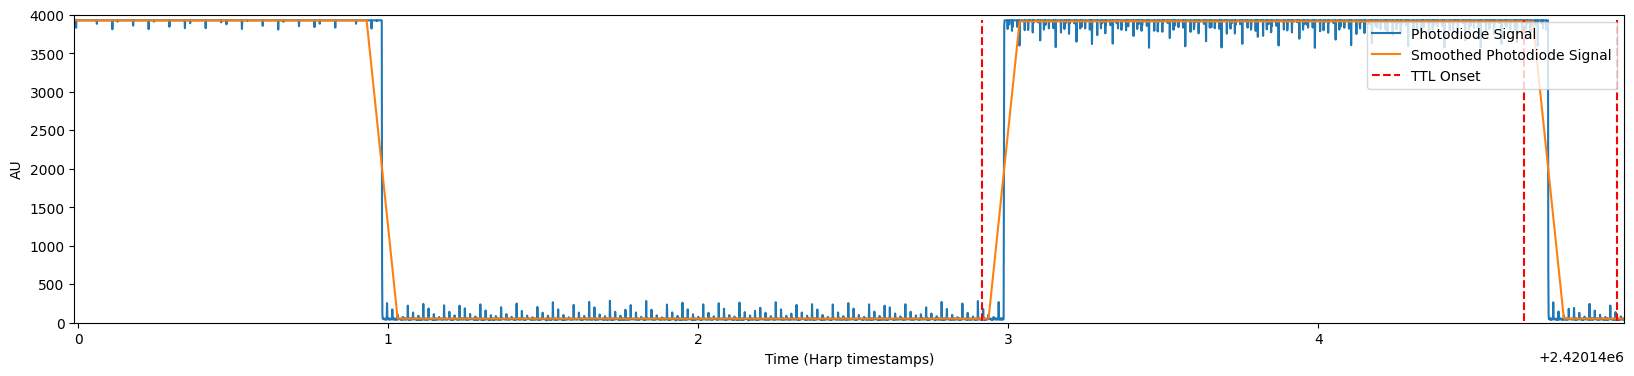

In [13]:
# Grab photodiode data
photodiode = behavior_reader.AnalogData.read()

# Keep only Time and AnalogInput0 columns
photodiode = photodiode['AnalogInput0']

# smooth photodiode signal over 100 samples (0.1 seconds)
photodiode_smoothed = photodiode.rolling(window=100, center=True).mean()
# # Choose trials to plot
trial_start_num = 10
trial_end_num=11

# Find Timestamps for these trials
t_start = trials_df['TrialStart_harp'].iloc[trial_start_num]
t_end = trials_df['TrialStart_harp'].iloc[trial_end_num+1]


# get timestamps of start of aborted trials from trials_df
aborted_trials = trials_df[trials_df['ChoicePort'] == -1]

ttl_onset_times = ttl_state_df[ttl_state_df['state'] == 1]['timestamp']
ttl_offset_times = ttl_state_df[ttl_state_df['state'] == 0]['timestamp']

# # plot the diode trace, draw points at the TTL onsets. Restrict plot to chosen trial (2 seconds either side of TTL)
plt.figure(figsize=(20, 4))
plt.xlim(t_start-2, t_end+2)
plt.xlim(t_start+20, t_start+25)

plt.ylim(0, 4000)
plt.plot(photodiode, label = 'Photodiode Signal')
plt.plot(photodiode_smoothed, label = 'Smoothed Photodiode Signal')
plt.vlines(ttl_onset_times, ymin=photodiode.min(), ymax=photodiode.max(), color='r', linestyle='--', label='TTL Onset')
plt.xlabel('Time (Harp timestamps)')
plt.ylabel('AU')
plt.legend(loc = 'upper right')


Find a reasonable threshold to distinguish between the "Dot on" and "Fail State On" states of the smoothed photodiode signal

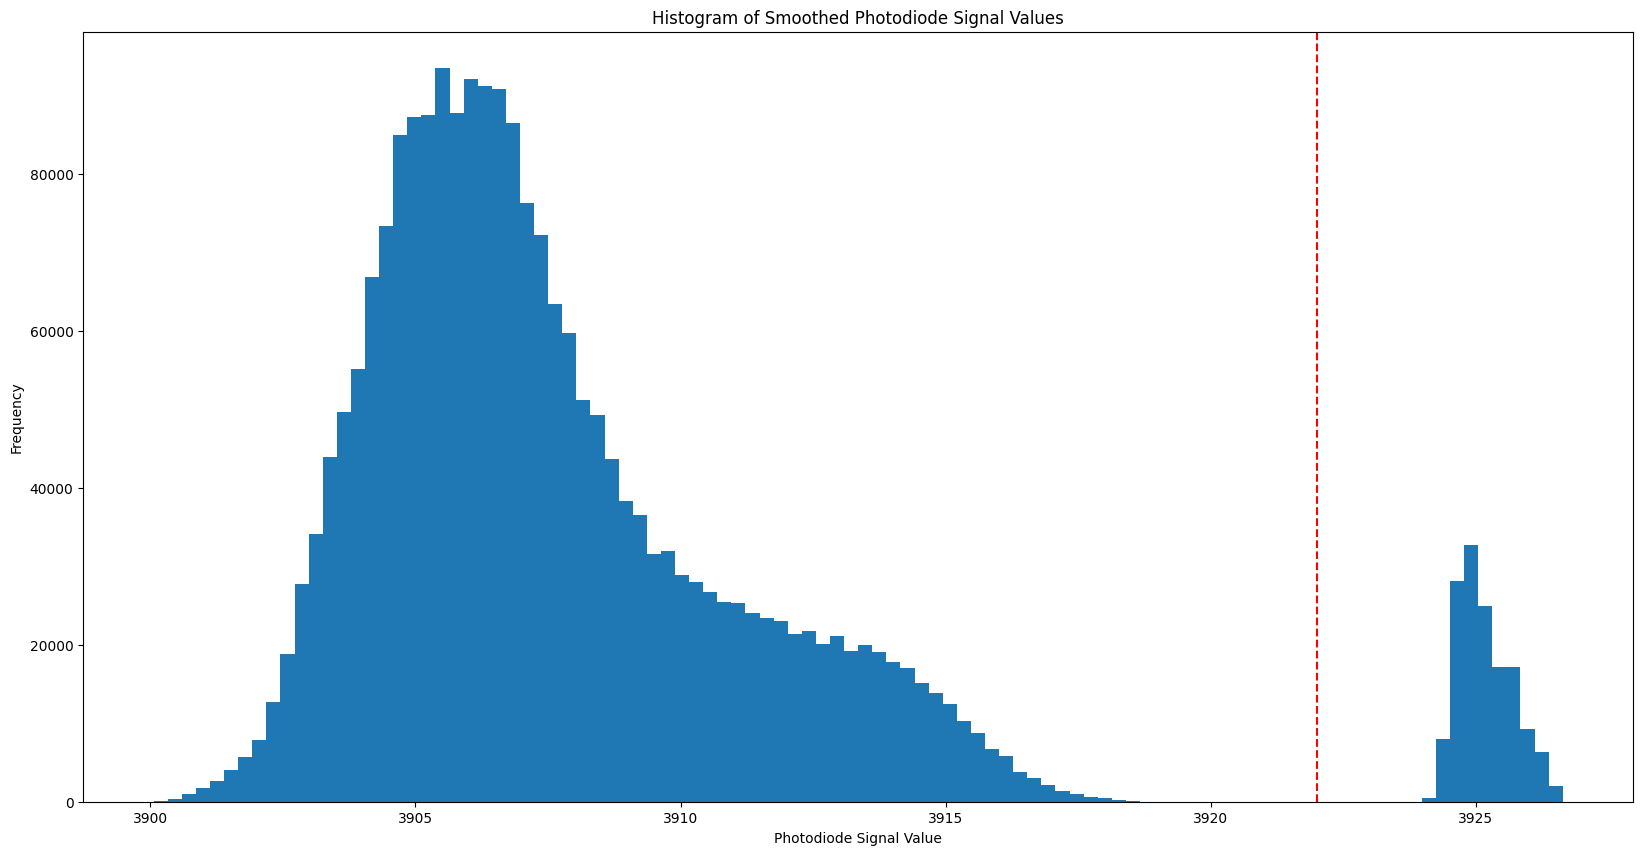

In [14]:
# Get histogram of smoothed photodiode signal values for values above 3900
plt.figure(figsize=(20, 10))
plt.hist(photodiode_smoothed[photodiode_smoothed > 3900], bins=100)
plt.xlabel('Photodiode Signal Value')
plt.ylabel('Frequency')
plt.title('Histogram of Smoothed Photodiode Signal Values')

fail_state_threshold = 3922

# mark abort state threshold on x-axis of histogram
plt.axvline(x=fail_state_threshold, color='r', linestyle='--', label='Fail State Threshold')

**Method 1** 
Try smoothing and binning into 3 distinct states:
- 0 indicates a resting state
- 1 indicates a state in which the dot is projected
- 2 indicates a fail state (in which the arena lights are on)

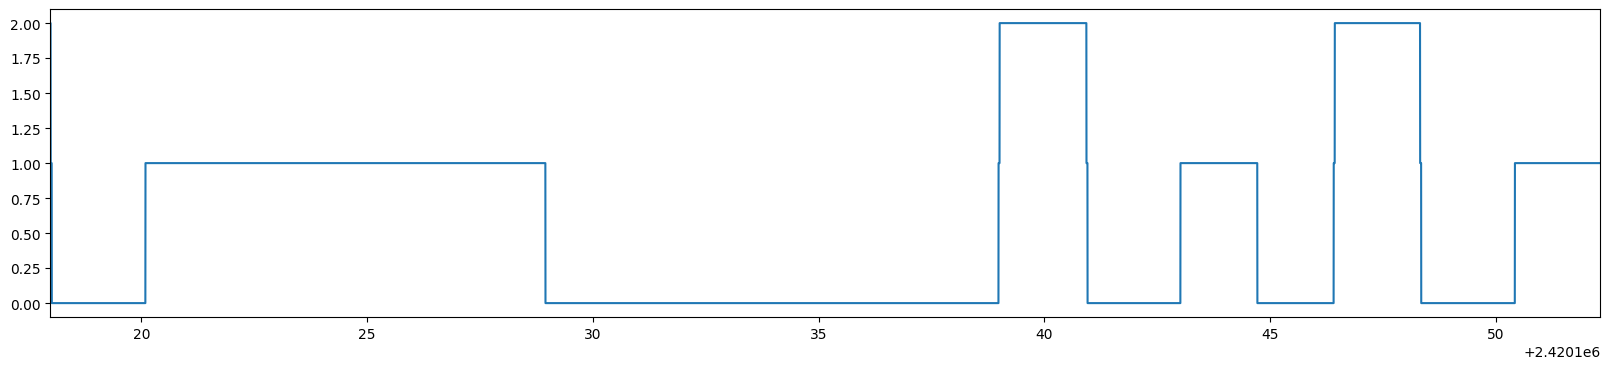

In [15]:
dot_on_threshold = 3000 # (Set on the higher end so it is more robust to noise if door is open)
fail_state_threshold = 3922

# Function to map values to 0, 1, or 2 based on the thresholds
def map_photodiode_state(photodiode_signal):
    if photodiode_signal < dot_on_threshold:
        return 0
    elif dot_on_threshold <= photodiode_signal < fail_state_threshold:
        return 1
    elif photodiode_signal >= fail_state_threshold:
        return 2

photodiode_state = photodiode_smoothed.apply(map_photodiode_state)

# # plot the diode trace, draw points at the TTL onsets. Restrict plot to chosen trial (2 seconds either side of TTL)
plt.figure(figsize=(20, 4))
plt.xlim(t_start-2, t_end+2)
plt.plot(photodiode_state, label = 'Photodiode State')


**Method 2** Apply threshold to local minima
1. Get y-values of all minima in raw photodiode signal
2. Apply thresholding

In [16]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

# Get indices of local minima in the photodiode signal
minima_indices = argrelextrema(photodiode.values, np.less)[0]

# Convert integer indices to time-based indices
minima_time_indices = photodiode.index[minima_indices]

# Get a time series of all local minima in photodiode signal
minima_ts = photodiode.loc[minima_time_indices]

# # Get the values and timestamps of the minima
# minima_values = photodiode.loc[minima_time_indices, 'AnalogInput0']
# minima_timestamps = minima_time_indices

Text(0, 0.5, 'AU')

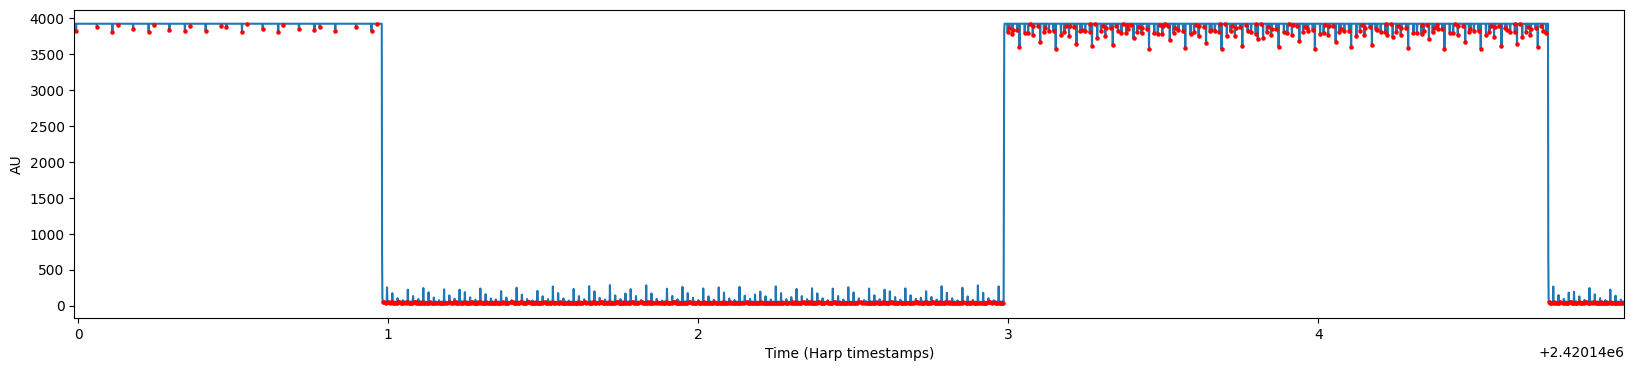

In [17]:
# Plot the photodiode signal between t_start and t_end with minima marked
plt.figure(figsize=(20, 4))
plt.xlim(t_start-2, t_end+2)
plt.xlim(t_start+20, t_start+25)

plt.plot(photodiode, label = 'Photodiode Signal', zorder=1)
plt.scatter(minima_ts.index, minima_ts.values, color='r', label='Minima', s=5, zorder =2)
plt.xlabel('Time (Harp timestamps)')
plt.ylabel('AU')


**Method 3** Thresholding and averaging 

1. Apply the dot onset threshold (2000AU) to the raw signal to distinguish state 0 from states 1 and 2
2. Take average of signal for each instances of states 1 and 2 and distinguish them with a second fail state threshold (3922AU)

**Note!**: the outputs from this method will have to be checked for instances in stage 5 where we go straight from state 1 to state 2. 

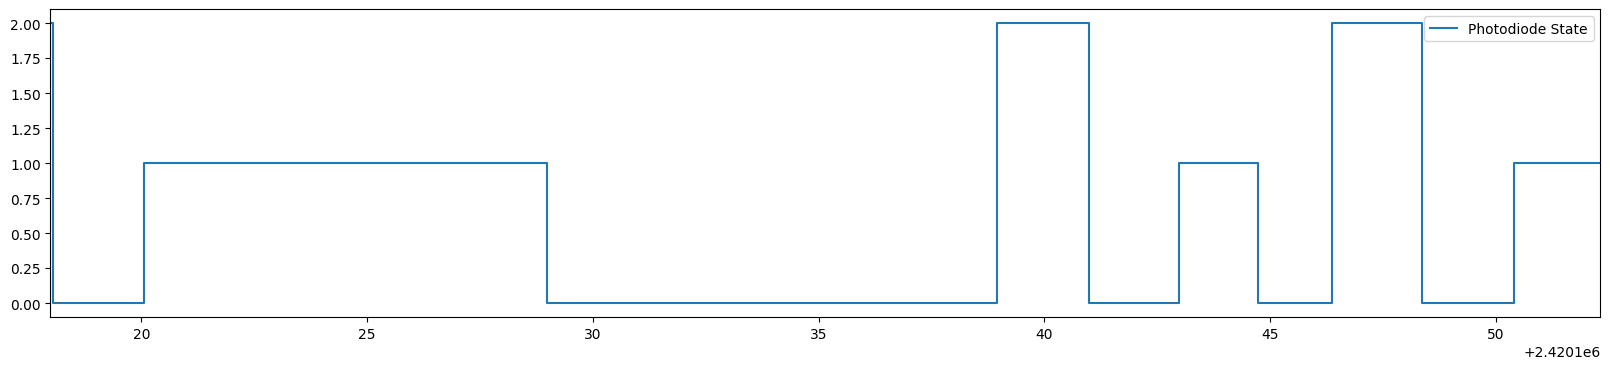

,timestamp,state,AvgPhotodiodeSignal
0,2.419931e+06,1.0,2682.333333
1,2.419931e+06,0.0,2336.333333
2,2.419931e+06,1.0,2596.000000
3,2.419931e+06,0.0,1787.333333
4,2.419931e+06,1.0,2987.000000
...,...,...,...
822,2.423138e+06,2.0,3923.418535
823,2.423140e+06,0.0,56.425299
824,2.423143e+06,1.0,3904.081942
825,2.423145e+06,0.0,54.562774


In [18]:
def get_square_wave(df): 

    # Create a new DataFrame with repeated elements
    square_wave = {'timestamp': df['timestamp'].repeat(2).tolist()[1:],
        'state': df['state'].repeat(2).tolist()[:-1]
        }
    square_wave = pd.DataFrame(square_wave)
    return square_wave

def map_photodiode_state(dot_on_threshold, fail_state_threshold, photodiode):

    # Map values to 0 or 1 based on the threshold using a lambda function
    photodiode_state = photodiode.apply(lambda x: 0 if x < dot_on_threshold else 1)

    # Get indices at which photodiode state changes
    photodiode_state_diff = photodiode_state.diff()
    photodiode_state_change_indices = pd.Index([photodiode_state.index[0]]).union(
        photodiode_state_diff[photodiode_state_diff != 0].index
    )

    # Iterate through the indices of state changes
    rows = []
    for i in range(len(photodiode_state_change_indices) - 1):
        start_idx = photodiode_state_change_indices[i]
        end_idx = photodiode_state_change_indices[i + 1]
        state = photodiode_state[start_idx]
        avg_signal = photodiode[start_idx:end_idx].mean()
        rows.append([start_idx, state, avg_signal])

    # Handle the last state change to the end of the series
    start_idx = photodiode_state_change_indices[-1]
    state = photodiode_state[start_idx]
    avg_signal = photodiode[start_idx:].mean()
    rows.append([start_idx, state, avg_signal])

    photodiode_state_df = pd.DataFrame(rows, columns=['timestamp', 'state', 'AvgPhotodiodeSignal'])

    # Mark state 2 (fail state) based on a second threshold
    photodiode_state_df['state'] = photodiode_state_df.apply(
        lambda row: 2 if row['AvgPhotodiodeSignal'] > fail_state_threshold else row['state'], axis=1
    )

    return photodiode_state_df

dot_on_threshold = 3000
fail_state_threshold = 3922

photodiode_state_df = map_photodiode_state(dot_on_threshold, fail_state_threshold, photodiode)

# Get a Series where the index is Timestamp from df_state_changes and the values are State
photodiode_state = pd.Series(photodiode_state_df['state'].values, index=photodiode_state_df['timestamp'])

# Plot the diode trace, draw points at the TTL onsets. Restrict plot to chosen trial (2 seconds either side of TTL)
plt.figure(figsize=(20, 4))
plt.xlim(t_start-2, t_end+2)
state_changes_trace = get_square_wave(photodiode_state_df)
plt.plot(state_changes_trace['timestamp'], state_changes_trace['state'], label='Photodiode State')
plt.legend()
plt.show()

photodiode_state_df